In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn import preprocessing
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import platform; print(platform.platform())
import sys; print("Python", sys.version)
import numpy; print("NumPy", numpy.__version__)
import scipy; print("SciPy", scipy.__version__)
import sklearn; print("Scikit-Learn", sklearn.__version__)
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
%matplotlib inline
from collections import OrderedDict
%config InlineBackend.figure_format = 'retina'

Linux-5.4.0-67-generic-x86_64-with-debian-bullseye-sid
Python 3.7.3 (default, Mar 27 2019, 22:11:17) 
[GCC 7.3.0]
NumPy 1.19.5
SciPy 1.6.0
Scikit-Learn 0.24.1


In [2]:
%store -r common_de
common_de.drop(['Pathway'],inplace=True,axis=1)
common_de.drop_duplicates(inplace=True)

In [3]:
common_de.shape

(48292, 17)

<AxesSubplot:ylabel='y'>

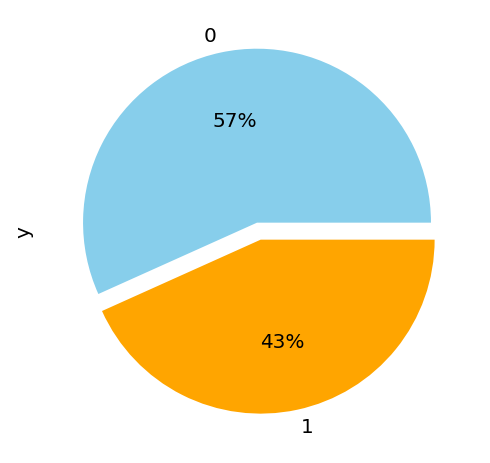

In [4]:
common_de.y.value_counts().plot(kind='pie', autopct='%1.0f%%', colors=['skyblue', 'orange'],
                                                      explode=(0.05, 0.05))

In [5]:
keep_samples =['BRCA']
common_DE_5samples = common_de[common_de['sample'].isin(keep_samples)]

In [6]:
up   =   common_de.query('logFC>=0.58')
down = common_de.query('logFC<=-0.58')

In [7]:
down.shape

(20286, 17)

In [23]:
data =up

In [25]:
data.drop('gene_sym',inplace=True,axis=1)

/home/alva/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [26]:
#data.drop(['gene_sym'],axis=1,inplace=True)
data['Meth_Mean']     =pd.to_numeric(data.Meth_Mean, errors='coerce')
data['sphase_mean_FC']=pd.to_numeric(data.sphase_mean_FC, errors='coerce')


/home/alva/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/alva/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [27]:
cat_vars=['proximal_cancer_driver','proximal_drug_target','negative_correlated_methylation','positive_correlated_methylation', 'promoter_methylated',
 'triplex','sample','types','mechanism','functional','clinical']
for var in cat_vars:
    cat_list = 'var '+'_'+ var
    cat_list = pd.get_dummies(data[var], prefix=var)
    data1    = data.join(cat_list)
    data     = data1
cat_vars=['proximal_cancer_driver','proximal_drug_target','negative_correlated_methylation','positive_correlated_methylation', 'promoter_methylated',
 'triplex','sample','types','mechanism','functional','clinical']
data_vars    = data.columns.values.tolist()
to_keep      = [i for i in data_vars if i not in cat_vars]

In [28]:
data_final = data[to_keep]
data_final = data_final.replace(['o','t','ot'],1)

In [29]:
data_final=data_final.replace(['unknown', 'Yes'], 
                     [0,1])
data_final=data_final.fillna(0)

In [30]:
data_final = data_final.replace('yes',1)
data_final.head()

,logFC,Meth_Mean,sphase_mean_FC,y,risk_alelle_freq,proximal_cancer_driver_No,proximal_cancer_driver_Yes,proximal_drug_target_No,negative_correlated_methylation_No,negative_correlated_methylation_Yes,...,functional_0,functional_Cell Growth,functional_EMT,functional_Survival,functional_autophagy/Apoptosis,clinical_0,clinical_Circulating,clinical_Drug,clinical_Metastasis,clinical_Recurrence
2,0.988639,0.0,0.0,0,0.0,1,0,1,1,0,...,1,0,0,0,0,0,0,0,1,0
3,0.988639,0.0,0.0,0,0.0,1,0,1,1,0,...,1,0,0,0,0,0,0,0,0,1
16,0.736331,0.0,0.0,0,0.0,1,0,1,1,0,...,1,0,0,0,0,0,0,0,1,0
17,0.736331,0.0,0.0,0,0.0,1,0,1,1,0,...,1,0,0,0,0,0,0,0,0,1
57,0.966222,0.0,0.0,1,0.0,1,0,1,1,0,...,1,0,0,0,0,1,0,0,0,0


In [31]:
X  = data_final.loc[:, data_final.columns != 'y']
y  = data_final.loc[:, data_final.columns == 'y']
os = SMOTE(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [32]:
columns   = X_train.columns
os_data_X,os_data_y=os.fit_resample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y = pd.DataFrame(data=os_data_y,columns=['y'])

In [33]:
# Check the numbers of our data
print("length of oversampled data is ",len(os_data_X))
print("Number of no pathways in oversampled data",len(os_data_y[os_data_y['y']==0]))
print("Number of pathways",len(os_data_y[os_data_y['y']==1]))
print("Proportion of no pathways data in oversampled data is ",len(os_data_y[os_data_y['y']==0])/len(os_data_X))
print("Proportion of pathways data in oversampled data is ",len(os_data_y[os_data_y['y']==1])/len(os_data_X))

length of oversampled data is  23122
Number of no pathways in oversampled data 11561
Number of pathways 11561
Proportion of no pathways data in oversampled data is  0.5
Proportion of pathways data in oversampled data is  0.5


In [34]:
data_final_vars=data_final.columns.values.tolist()
len(data_final_vars)

47

In [35]:
y=['y']
X=[i for i in data_final_vars if i not in y]
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
rfe = RFE(logreg, 47)
rfe = rfe.fit(os_data_X, os_data_y.values.ravel())
print(rfe.support_)
print(rfe.ranking_)

/home/alva/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_features_to_select=47 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1]


/home/alva/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [42]:
cols = os_data_X.columns[rfe.support_].tolist()
X=os_data_X[cols]
y=os_data_y['y']

['logFC',
 'Meth_Mean',
 'sphase_mean_FC',
 'risk_alelle_freq',
 'proximal_cancer_driver_No',
 'proximal_cancer_driver_Yes',
 'proximal_drug_target_No',
 'negative_correlated_methylation_No',
 'negative_correlated_methylation_Yes',
 'positive_correlated_methylation_No',
 'positive_correlated_methylation_Yes',
 'promoter_methylated_No',
 'promoter_methylated_Yes',
 'triplex_No',
 'triplex_Yes',
 'sample_BRCA',
 'sample_COAD',
 'sample_ESCA',
 'sample_HNSC',
 'sample_KICH',
 'sample_KIRC',
 'sample_KIRP',
 'sample_LIHC',
 'sample_LUAD',
 'sample_LUSC',
 'sample_PRAD',
 'sample_STAD',
 'sample_THCA',
 'types_0',
 'types_o',
 'types_ot',
 'types_t',
 'mechanism_0',
 'mechanism_Enhancer',
 'mechanism_TF',
 'mechanism_Variant',
 'functional_0',
 'functional_Cell Growth',
 'functional_EMT',
 'functional_Survival',
 'functional_autophagy/Apoptosis',
 'clinical_0',
 'clinical_Circulating',
 'clinical_Drug',
 'clinical_Metastasis',
 'clinical_Recurrence']

In [39]:
import statsmodels.api as sm
logit_model = sm.Logit(y,X)
result      = logit_model.fit()
print(result.summary2())

         Current function value: 0.557738
         Iterations: 35
                                           Results: Logit
Model:                          Logit                        Pseudo R-squared:             0.195     
Dependent Variable:             y                            AIC:                          25882.0256
Date:                           2021-03-22 11:36             BIC:                          26244.2099
No. Observations:               23122                        Log-Likelihood:               -12896.   
Df Model:                       44                           LL-Null:                      -16027.   
Df Residuals:                   23077                        LLR p-value:                  0.0000    
Converged:                      0.0000                       Scale:                        1.0000    
No. Iterations:                 35.0000                                                              
------------------------------------------------------------

/home/alva/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [40]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

logreg = LogisticRegression(class_weight="balanced",dual=False, fit_intercept=False,intercept_scaling=1,
                   max_iter=100,multi_class='ovr',n_jobs=1, penalty='l2',random_state=None,solver='liblinear',tol=0.0001,
                  verbose=0,warm_start=False,C = 1e9)

logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.64


Up_only accuracy: 64/ all features

Down only accuracy: 61 all features

Improve the accuracy of the model